# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Четвертая лабораторная работа </center>
# <center> Акустические признаки </center>

In [ ]:
import librosa
import numpy as np
import scipy 
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib
from glob import glob
import os
import sklearn

%matplotlib inline

In [ ]:
# Функция отрисовки аудио сигнала. 
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveplot(wav, sr=sr)
    plt.show()



In [ ]:
# Для выполнения задания нам понадобится датасет yes/no. 
# Про датасет можно почитать тут https://www.openslr.org/1/

# Скачаем его
![ ! -f  waves_yesno.tar.gz ] && wget https://www.openslr.org/resources/1/waves_yesno.tar.gz
# И распакуем
!tar -xvzf waves_yesno.tar.gz

# P.S если у вас Windows, или по каким-либо еще причинам данные не скачались, 
# то их можно скачать руками отсюда: https://www.openslr.org/1/

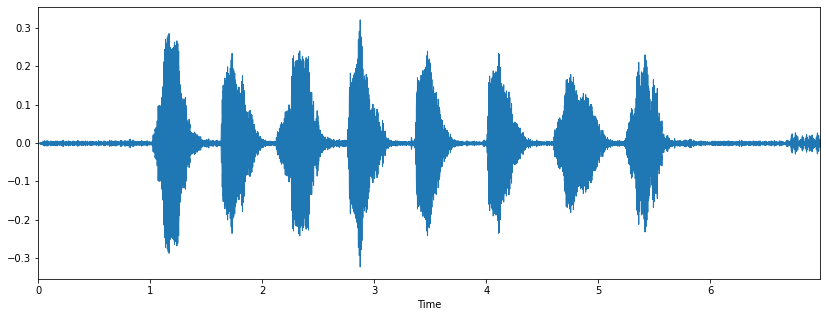

In [ ]:
# Загрузим один из файлов
wav, sr = librosa.load("waves_yesno/0_1_0_1_1_1_0_0.wav")
draw_waveform(wav, sr)
ipd.Audio(wav, rate=sr)

Как можно услышать, в этом датасете произносятся какие-то два слова (yes/no на иврите). Каждый файл состоит из 8 произнесений. Метки слов указаны в названиях файлов.

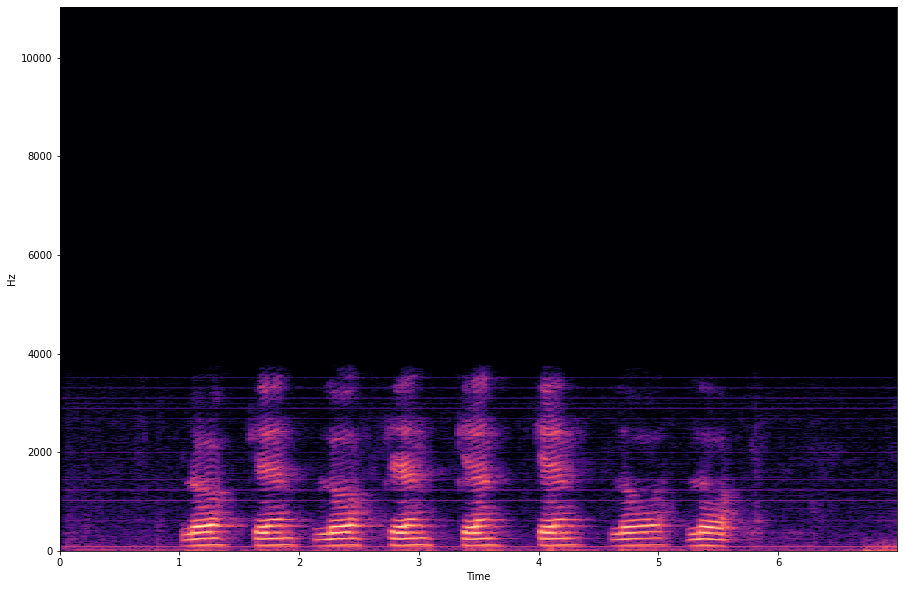

In [ ]:
# Построим спектрограмму загруженной вавки
stft = librosa.stft(wav)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(15,10))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz')

# Классификация слов
Построим простую систему, классифицирующую слова yes/no.

Загрузим весь датасет

In [ ]:
def load_yn_dataset(directory):
    X, labels = [], []
    bad_files = set(["0_1_0_1_0_0_0_0"])
    for f in glob(directory +"/*.wav"):
        name = os.path.basename(f)[:-4]
        if name in bad_files:
            continue
        y = [int(l) for l in name.split("_")]
        x, _ = librosa.load(f)
        X.append(x)
        labels.append(y)
        
    return X, labels
        
X, Y = load_yn_dataset("waves_yesno/")

Отделим 20% для теста

In [ ]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y,test_size=0.2, random_state=1)

# Задание *5 (1 балл)
Voice Activity Detector (VAD) определяет, есть ли речь в текущем кадре.
Реализуйте простой VAD. Настройте VAD, чтобы хорошо определялись границы слов.

Подсказка:
Можно отличать паузу от речи по энергии mfcc спектра( или части спектра). Чтобы предотвратить скачки на краях слов, воспользуйтесь сверткой со сглаживающим окном, например, Ханна.

In [ ]:
X_train[0]

array([ 0.04503657,  0.05263549,  0.05247283, ..., -0.00137151,
       -0.00094018, -0.00041117], dtype=float32)

In [ ]:
# YOUR CODE HERE

# train_VA = # List[np.ndarray]. 1 - Voice, 0 - silence
# test_VA = # List[np.ndarray]. 1 - Voice, 0 - silence
        
#

import librosa

from scipy.signal import get_window

y, sr = librosa.load('/content/waves_yesno/0_0_0_0_1_1_1_1.wav')
n_fft = 25 * sr//1000
hop_length = 10 * sr//1000

meltspec_args = {"n_fft": n_fft, "hop_length": 10 * sr//1000, "window":  get_window("hamming", n_fft)}
mfccs = librosa.feature.mfcc(y=y, sr=sr, S=None, n_mfcc=12, **meltspec_args)

for 

print(mfccs.shape)



# def VAD()

In [ ]:
def smooth(x,window_len=17,window='hanning'):

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [ ]:
import scipy.signal as signal
from scipy.signal import argrelextrema
from scipy.signal import get_window


def VAD(data, N=3, Wn=0.1, window_ms=25, step_mc=10, n_mfcc=13, sr=22050):

    n_fft = window_ms * sr//1000
    hop_length = step_mc * sr//1000
    B, A = signal.butter(N, Wn, output='ba')
    VA = []
    meltspec_args = {"n_fft": n_fft, "hop_length": hop_length, "window":  get_window("parzen", n_fft)}
    for audio in data:
        # Сглаживание первого фильтра MFCC
        mfccs = librosa.feature.mfcc(y=np.array(audio), sr=sr, n_mfcc=n_mfcc, **meltspec_args)
        # print(mfccs.shape)
        smooth_data = smooth(mfccs[0], window='hamming')
        peaks = smooth_data[1:-1][np.diff(np.diff(smooth_data)) < 0]
        # print(peaks)
        
        idx_minimas = argrelextrema(smooth_data, np.less)[0]
        # print(idx_minimas)
        idx_maximas = argrelextrema(smooth_data, np.greater)[0]
        # print(idx_maximas)
        idx = np.sort(np.concatenate((idx_minimas, idx_maximas)))

        VA_sample = np.zeros(shape=audio.shape)

        dct_of_smooth = {}
        for i in idx:
            dct_of_smooth[i] = smooth_data[i]

        # Сортируем значения в словаре по убыванию, первые 8 точек соответствуют фреймам, когда была речь
        arr = sorted(dct_of_smooth.items(), key=lambda x: x[1], reverse=True)[:8]
        print(arr)

        # Добавляем коэффициент расширения
        coef = int(len(audio) / len(mfccs[0]))

        # Подбираем левую и правую границы найденного экстремума
        for id, _ in arr:
            VA_sample[coef*(id-10):coef*(id+10)] = 1

        VA.append(VA_sample)

    return np.array(VA)

In [ ]:
l = list(VA_test[1])
l.index(1.0)

27375

In [1]:
def test_VAD(VA, Y, min_acc=0.95):
    def check_ali(ali, num_words):
        diff = ali[1:]  - ali[:-1]
        if diff.sum()!=0:
            print("VAD detected speech at the beginning (or end) of audio")
            return -1 
        if not (diff > 0).sum() == (diff > 0).sum() ==  num_words:
            return -2
        return 0
    
    bad_i = []
    err =0
    for i, (ali, y) in enumerate(zip(VA, Y)):
        if check_ali(ali, len(y)) != 0:
            bad_i.append(i)
            err+=1
    acc = (len(Y) - err)/len(Y)
    print(f"Accuracy {acc}")
    if len(bad_i) >0:
        print(f"ids with error {bad_i}")
    assert acc >= min_acc , f"Accuracy must be >= {min_acc}"
    print("Test passed")

test_VAD(VA_train, Y_train)
test_VAD(VA_test, Y_test)
print("VAD ok!")

47 0
Accuracy 1.0
Test passed
12 0
Accuracy 1.0
Test passed
VAD ok!


# Задание *6 (2 балла)
Обучите классификатор, определяющий, какое слово было сказано. Используйте VAD для разбиения входных файлов на отдельные слова. Классификацию можно сделать, например, с помощью SVM по усредненным признаки выделеных VAD'ом слов. Или любым другим удобным для вас способом. Добейтесь точности больше 0.95

In [ ]:
import torch
from torch.optim import AdamW
from torch.nn import BCELoss
from torch.utils.data import DataLoader, TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm.notebook import tqdm
import seaborn as sns
from torchsummary import summary
import pandas as pd

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
def full_audio(data, VA, Y):
    full_audio_data = []
    target = []
    audio_samples = []
    i = 0

    for idx_audio, audio in enumerate(data):
      for idx_point, audio_point in enumerate(audio):
        if VA[idx_audio][idx_point] == 1.0 and VA[idx_audio][idx_point-1] == 0.0 and idx_point != 0:
          audio_samples.append([])
          audio_samples[i].append(audio_point)
        elif VA[idx_audio][idx_point] == 1.0 and VA[idx_audio][idx_point+1] == 0.0:
          audio_samples[i].append(audio_point)
          full_audio_data.append(audio_samples[i])
          target.append(Y[idx_audio][i % 8])
          i += 1
        elif VA[idx_audio][idx_point] == 1.0:
          audio_samples[i].append(audio_point)
    return np.array(full_audio_data), np.array(target)

def get_mfcc_audio(full_audio_data):
    return np.array([librosa.feature.mfcc(np.array(elem), sr) for elem in full_audio_data])

In [ ]:
full_audio_train, target_train = full_audio(X_train, VA_train, Y_train)
data_train = get_mfcc_audio(full_audio_train)
full_audio_test, target_test = full_audio(X_test, VA_test, Y_test)
data_test= get_mfcc_audio(full_audio_test)

In [ ]:
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(torch.Tensor(data_train), torch.Tensor(target_train), test_size=0.1, random_state=42)

In [ ]:
dataset_train = TensorDataset(X_train, y_train)
dataset_val = TensorDataset(X_val, y_val)
dataset_test = TensorDataset(torch.Tensor(data_test), torch.Tensor(target_test))

batch_size = 64
dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_val = DataLoader(dataset_val,
                              sampler=SequentialSampler(dataset_val),
                              batch_size=batch_size)

dataloader_test = DataLoader(dataset_test,
                              sampler=SequentialSampler(dataset_test),
                              batch_size=batch_size)

In [ ]:
class clf(nn.Module):
    def __init__(self):
        super(clf, self).__init__()

        self.conv_layers = nn.Sequential(
                                    nn.Conv2d(1, 32, kernel_size=(3,3), padding=1), 
                                    nn.ReLU(),
                                    nn.BatchNorm2d(32),
                                    nn.Conv2d(32, 32, kernel_size=(3,3), padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(32),
                                    # nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
                                    # nn.ReLU(),
                                    # nn.BatchNorm2d(64)
                                    )

        self.Linear1 = nn.Linear(32*20*8, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.Dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        # self.Linear2 = nn.Linear(128, 64)
        # self.bn2 = nn.BatchNorm1d(64)
        self.Linear2 = nn.Linear(128, 1)


    def forward(self, x):
        x = x.unsqueeze(dim=1) 
        x = self.conv_layers(x)
        x = torch.flatten(x, start_dim=1)
        x = self.bn1(self.relu(self.Linear1(x)))
        # x = self.Dropout(x)
        # x = self.bn2(self.relu(self.Linear2(x)))
        x = self.Linear2(x)
        return x

In [ ]:
model = clf().to(device)
optimizer = AdamW(model.parameters())
loss_fn = BCELoss()

In [ ]:
def learning_curves(data, txt='loss'):
    plt.figure(figsize=(8,6))
    sns.lineplot(data=data)
    plt.title('Training history', fontsize=14)
    plt.ylabel('{}'.format(txt), fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.legend(fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=14)

In [ ]:
def train(train_dataloader, val_dataloader, model, loss_fn, optimizer, epoch):
    losses_train = []
    accuracy_train = []
    losses_val = []
    accuracy_val = []
    for i in tqdm(range(epoch)):
        loss_train = []
        acc_train = []
        loss_val = []
        acc_val = []
        for d in train_dataloader:
            optimizer.zero_grad()
            model.train()
            X_train = d[0].to(device).float()
            y_train = d[1].to(device).float()
 
            probs = model(X_train)

            m = nn.Sigmoid()

            loss = loss_fn(m(probs), torch.unsqueeze(y_train, 1))

            y_pred_train = [1. if tmp > 0.5 else 0. for tmp in m(probs).cpu().detach().numpy()]
            acc_train.append(accuracy_score(y_pred_train, y_train.cpu().detach().numpy()))

            loss_train.append(loss.item())
            acc_train.append(accuracy_score(y_pred_train, y_train.cpu().numpy()))
            loss.backward()
            optimizer.step()
        losses_train.append(np.mean(loss_train))
        accuracy_train.append(np.mean(acc_train))
        if i % 1 == 0:
            model.eval()
            with torch.no_grad():
                optimizer.zero_grad()
                for d in val_dataloader:
                    X_val = d[0].to(device).float()
                    y_val = d[1].to(device).float()
                    probs = model(X_val)

                    loss = loss_fn(m(probs), torch.unsqueeze(y_val, 1))

                    y_pred_val = [1 if tmp > 0.5 else 0 for tmp in m(probs).cpu().detach().numpy()]
                    acc_val.append(accuracy_score(y_pred_val, y_val.cpu().detach().numpy()))
                    loss_val.append(loss.item())
            print('---Train---')
            print('Epoch: {}, Accuracy: {}, Loss: {}'.format(i, np.mean(acc_train), np.mean(loss_train)))
            print('---Validation---')
            print('Epoch: {}, Accuracy: {}, Loss: {}'.format(i, np.mean(acc_val), np.mean(loss_val)))
            print('')
            losses_val.append(np.mean(loss_val))
            accuracy_val.append(np.mean(acc_val))
    print('training finished')
    return {'loss_train': losses_train, 'loss_val': losses_val}, {'acc_train': accuracy_train, 'acc_val': accuracy_val}

In [ ]:
epoch = 10
history_loss, history_acc = train(dataloader_train, dataloader_val, model, loss_fn, optimizer, epoch)

  0%|          | 0/10 [00:00<?, ?it/s]

---Train---
Epoch: 0, Accuracy: 0.9088541666666666, Loss: 0.16800271533429623
---Validation---
Epoch: 0, Accuracy: 0.9736842105263158, Loss: 0.14120419323444366

---Train---
Epoch: 1, Accuracy: 1.0, Loss: 0.03996831364929676
---Validation---
Epoch: 1, Accuracy: 1.0, Loss: 0.0823826715350151

---Train---
Epoch: 2, Accuracy: 1.0, Loss: 0.021904792015751202
---Validation---
Epoch: 2, Accuracy: 1.0, Loss: 0.044101912528276443

---Train---
Epoch: 3, Accuracy: 1.0, Loss: 0.016542216762900352
---Validation---
Epoch: 3, Accuracy: 1.0, Loss: 0.02845424972474575

---Train---
Epoch: 4, Accuracy: 1.0, Loss: 0.01434430480003357
---Validation---
Epoch: 4, Accuracy: 1.0, Loss: 0.02033691108226776

---Train---
Epoch: 5, Accuracy: 1.0, Loss: 0.010272927892704805
---Validation---
Epoch: 5, Accuracy: 1.0, Loss: 0.013591168448328972

---Train---
Epoch: 6, Accuracy: 1.0, Loss: 0.00961655161033074
---Validation---
Epoch: 6, Accuracy: 1.0, Loss: 0.010290643200278282

---Train---
Epoch: 7, Accuracy: 1.0, Loss

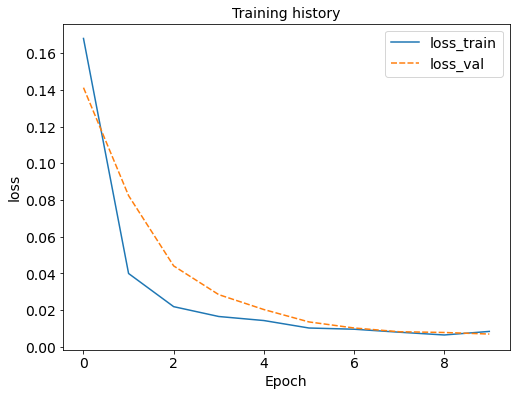

In [ ]:
learning_curves(history_loss)

In [ ]:
def get_predictions_for_cv(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    y_pred = []
    y_test = []
    acc = []
    with torch.no_grad():
        for data in data_loader:
            X_test = data[0].to(device).float()
            y_test_ = data[1].to(device).float()
            preds = model(X_test)
            m = nn.Sigmoid()
            y_pred_test = [1. if tmp > 0.5 else 0. for tmp in m(preds).cpu().detach().numpy()]
            acc.append(accuracy_score(y_pred_test, y_test_.cpu().detach().numpy()))
            y_pred.extend(y_pred_test)
            y_test.extend( y_test_.cpu().detach().numpy())
    print('Accuracy: {}'.format(np.mean(acc)))
    return y_pred, y_test

In [ ]:
y_pred, y_test = get_predictions_for_cv(model, dataloader_test)

Accuracy: 1.0


In [ ]:
def show_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(10,8))
    hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", annot_kws={"fontsize":18})
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment', fontsize=18)
    plt.xlabel('Predicted sentiment', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show()

In [ ]:
from sklearn.metrics import classification_report
class_names = ['no', 'yes']
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

          no       1.00      1.00      1.00        41
         yes       1.00      1.00      1.00        55

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96



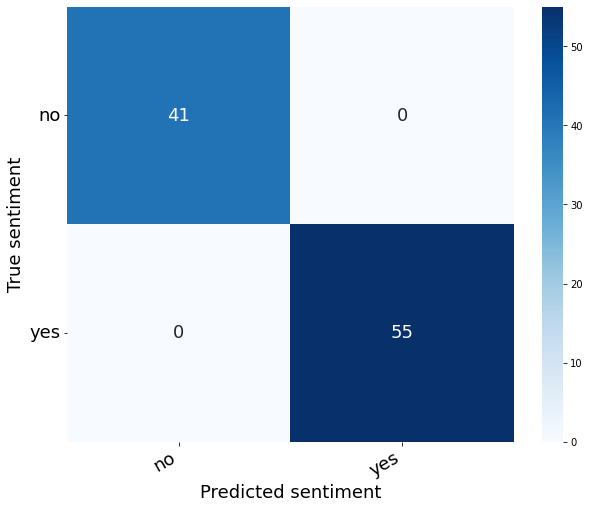

In [ ]:
show_confusion_matrix(y_test, y_pred)